In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [2]:
# Initial states
roll_0 = 5 # theta 1
pitch_0 = 5 # theta 2
yaw_0 = 5 # theta 3

roll_deriv_0 = 0 # omega 1
pitch_deriv_0 = 0 # omega 2
yaw_deriv_0 = 0 # omega 3

# Desired angles (reference angles)
roll_reff = 0
pitch_reff = 0
yaw_reff = 0

# Creater initial states
initial_state = np.deg2rad(np.array([roll_0, 
                          pitch_0,
                          yaw_0, 
                          roll_deriv_0, 
                          pitch_deriv_0,
                          yaw_deriv_0]))

# Data on spacecraft
J = np.array([2700, 2300, 3000])
disturbance_torque=np.array([0.001, 0.001, 0.001]) 
#disturbance_torque=np.array([0, 0, 0]) 

# Data on orbit
mu = 3.986004418e14
a = 6371e3 + 700e3
period = 2 * np.pi * np.sqrt(a**3/mu)
n = 2 * np.pi / period

print(period)

5917.417835241439


In [3]:
# Dynamics and Kinematics of the euler angles describing the rotation between the body fixed frame (b) and the local vertical/horizontal reference frame (a)
def EoM(t, y, control_torque):
    
    deriv = np.zeros(6)
    
    M = np.array([[np.cos(y[1]), np.sin(y[0])*np.sin(y[1]),  np.cos(y[0])*np.sin(y[1])], 
                  [0,            np.cos(y[0])*np.cos(y[1]),  - np.sin(y[0]) * np.cos(y[1])], 
                  [0,            np.sin(y[0]),               np.cos(y[0])]])
                   
    # Kinetmatic differential equation
    deriv[:3] = (1 / np.cos(y[1])) * M @ y[3:] + (n/np.cos(y[1])) * np.array([np.sin(y[2]), np.cos(y[1])*np.cos(y[2]), np.sin(y[1])*np.sin(y[2])])
    
    # Dynamic equations of motion
    deriv[3] = J[0]**(-1.) * ((J[1] - J[2]) * y[4]*y[5] - 3 * n**2 * (J[1] - J[2]) * np.sin(y[0]) * np.cos(y[1]) * np.cos(y[0]) * np.cos(y[1]) + control_torque[0] + disturbance_torque[0])
    deriv[4] = J[1]**(-1.) * ((J[2] - J[0]) * y[5]*y[3] + 3 * n**2 * (J[2] - J[0]) * np.cos(y[0]) * np.cos(y[1]) * np.sin(y[1]) + control_torque[1] + disturbance_torque[1])
    deriv[5] = J[2]**(-1.) * ((J[0] - J[1]) * y[3]*y[4] + 3 * n**2 * (J[0] - J[1]) * np.sin(y[1]) * np.sin(y[0]) * np.cos(y[1]) + control_torque[2] + disturbance_torque[2])

    return deriv

In [4]:
def PID(angle, integrated, derivative, p, i, d):
    moment = p * angle + i * integrated + d * derivative
    return moment

In [5]:
def simulate_attitude(termination_time = 300, 
            dt_control = 2, 
            p = [0, 0, 0],
            i = [0., 0., 0],
            d = [0., 0, 0], 
            gyro_bias = False, 
            attitude_noise = False, 
            state_estimation = False):
    
    # Prepare simulations
    time = 0
    control_torque = np.array([0, 0, 0])
    state_history = np.array([np.concatenate((np.array([time]), initial_state))])
    state_history_m = np.array([])
    
    # Control loop
    while time < termination_time:

        #==========================================
        # Simulate the real dynamics
        #==========================================
        result = integrate.solve_ivp(EoM, (time, time + dt_control), 
                                     state_history[-1, 1:], 
                                     rtol = 1e-10, 
                                     atol = 1e-10,
                                     args = [control_torque])

        # Extract time and states except for initial state
        states = result.y.T[1:]
        times = result.t[1:]

        # Store history
        states_with_time = np.concatenate((times.reshape(-1, 1), states), axis = 1) 
        state_history = np.append(state_history, states_with_time, axis = 0) 
        
        #==================================
        # Simulate the measurements 
        # (with noise)
        # TODO
        #==================================
        
        if attitude_noise:
            attitude_measurements = states[:,1:4
        else:
            attitude_measurements = state_history[
        
        if gyro_noise: 
            
            #TODO
            pass
        else:
            
            pass
        

        #==================================
        # State estimation (EKF)
        # TODO
        #==================================
        
        if state_estimation: 
            #TODO
            pass

        #==================================
        # Control (PD)
        #==================================
        
        # Extract proportional error
        roll_error = 1 * (roll_reff - states[-1, 0] )
        pitch_error = 1 * (pitch_reff - states[-1, 1])
        yaw_error = 1 * ( yaw_reff - states[-1, 2])

        # Extract derivative of error
        roll_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[0]
        pitch_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[1]
        yaw_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[2]

        # Extract integration of error
        roll_int = -1*integrate.trapezoid(result.y.T[:,0], x=result.t)
        pitch_int = -1*integrate.trapezoid(result.y.T[:,1], x=result.t)
        yaw_int = -1*integrate.trapezoid(result.y.T[:,2], x=result.t)

        # roll_int = -1 *  integrate.trapezoid(state_history[:,1], x=state_history[:,0])
        # pitch_int = -1 * integrate.trapezoid(state_history[:,2], x=state_history[:,0])
        # yaw_int = -1 * integrate.trapezoid(state_history[:,3], x=state_history[:,0])

        # Find the control torque 
        roll_moment = PID(roll_error, roll_int, roll_vel, p[0], i[0], d[0])
        pitch_moment = PID(pitch_error, pitch_int, pitch_vel, p[1], i[1], d[1])
        yaw_moment = PID(yaw_error, yaw_int, yaw_vel, p[2], i[2], d[2])

        
        #========================================
        # Prepating to move to next control node
        #========================================
        
        # Update time and control torque and print progress
        control_torque = np.array([roll_moment, pitch_moment, yaw_moment])
        time = time + dt_control
        print("Progress = ", time*100/termination_time, "%", end="\r")
        
    return state_history, state_history_m

In [9]:
# https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method
# Ziegler-Nichols method 
Ku1 = 15
Kt1 = 87

Ku2 =  15
Kt2  = 81

Ku3 = 15
Kt3 = 90

# # Trial
# state_history = simulate(termination_time = 100, 
#             dt_control = 2,
#             p = [15, 15, 15],
#             i = [0, 0, 0],
#             d = [0, 0, 0])

# PD 
state_history = simulate_attitude(termination_time = period, 
            dt_control = 10,
            p = [0.8*Ku1, 0.8 * Ku2, 0.8 * Ku3],
            i = [0, 0, 0],
            d = [1.5 * 0.1 * Kt1 * Ku1, 1.5 * 0.1 * Kt2 * Ku2, 1.5 *  0.1 * Kt3 * Ku3])

# # PID
# state_history = simulate_attitude(termination_time = 3 * period, 
#             dt_control = 10,
#             p = [0, 0.6 * Ku, 0],
#             i = [0, 1.2 * Ku/Kt, 0],
#             d = [0, 0.075 * Ku * Kt, 0])

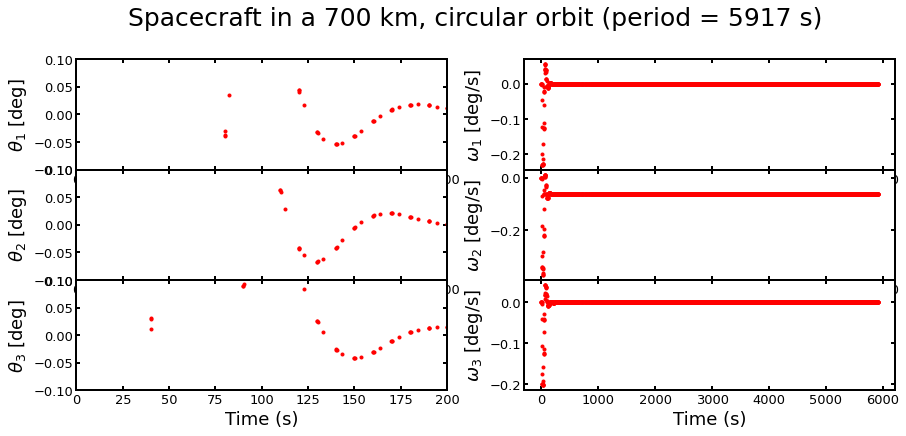

In [13]:
labels = [r"$\theta_1$ [deg]", r"$\theta_2$ [deg]", r"$\theta_3$ [deg]",
          "$\omega_1$ [deg/s]", "$\omega_2$ [deg/s]", "$\omega_3$ [deg/s]"]

fig, axes = plt.subplots(3, 2, figsize = (13, 6))
fig.tight_layout(pad=4)
fig.suptitle("Spacecraft in a 700 km, circular orbit (period = %.i s)" % period, fontsize = 25, y = 1.02)
fig.subplots_adjust(hspace=0)
axes[2, 0].set_xlabel("Time (s)", fontsize = 18)
axes[2, 1].set_xlabel("Time (s)", fontsize = 18)

for ax in axes[:,0]:
    ax.set_xlim(0, 200)
    ax.set_ylim(-5, 6)

    ax.set_xlim(0, 200)
    ax.set_ylim(-0.1, 0.1)

for i, ax in enumerate(axes.T.flat): 
    
    ax.plot(state_history[:,0], np.rad2deg(state_history[:,1+i]), 'ro', markersize = 3)
    ax.set_ylabel(labels[i], fontsize = 18) 
    #ax.axvline(81)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)

##### print(2*np.std(np.rad2deg(state_history[:,2])))

In [14]:
print(state_history)

[[ 0.00000000e+00  8.72664626e-02  8.72664626e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.90488044e-02  8.72682323e-02  8.72866120e-02 ...  8.49441100e-09
   9.00905088e-09  6.41461642e-09]
 [ 2.09536849e-01  8.72859387e-02  8.74881144e-02 ...  9.34398309e-08
   9.91086904e-08  7.05616704e-08]
 ...
 [ 5.91011110e+03  8.33552612e-05  8.33403803e-05 ... -8.84876598e-08
  -1.06181200e-03  8.85002422e-08]
 [ 5.91111110e+03  8.33552612e-05  8.33403803e-05 ... -8.84876598e-08
  -1.06181200e-03  8.85002422e-08]
 [ 5.92000000e+03  8.33552612e-05  8.33403803e-05 ... -8.84876598e-08
  -1.06181200e-03  8.85002422e-08]]
